# Fine Mapping

I want to take the significant eQTL variants and functionally annotate them
to come up with a list of variants that might be causal. There is a lot of
functional data for the H1-hESC line that I can use along with data from
other places.

In [1]:
import cPickle
import glob
import os
import re
import subprocess
import urllib2

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import tabix
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'fine_mapping'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
transcript_to_gene = pd.read_table(cpy.gencode_transcript_gene, header=None, 
                                   squeeze=True, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'lead_variants_single.tsv')
lead_variants_single = pd.read_table(fn, index_col=0)
lead_variants_single_f = lead_variants_single[lead_variants_single.perm_sig]

genes = pbt.BedTool(cpy.gencode_gene_bed)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'gene_variant_pairs.tsv')
gene_variants = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis',
                  'encode_stem_cell_chip_seq.tsv')
encode_chip_seq = pd.read_table(fn, index_col=0)

ensg = pd.Series(gene_info.index, index=[x.split('.')[0] for x in gene_info.index])

fn = os.path.join(ciepy.root, 'output', 'cnv_analysis', 'cnv_gene_variants.pickle')
cnv_gv = pd.read_pickle(fn)

In [3]:
# ASE results.
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

snv_res = {}
for fn in snv_fns:
    snv_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

snv_p = pd.Panel(snv_res)

In [4]:
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'matrices.pickle')
with open(fn) as f:
    matrices = cPickle.load(f)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_full.tsv')
motif_info = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_rep.tsv')
motif_info_rep = pd.read_table(fn, index_col=0)
motif_info['target'] = [x.split('_')[0] for x in motif_info.index]

I'll drop CNVs since they likely act through different mechanisms than I'm considering here.

In [5]:
n = gene_variants.shape[0]
print('{:,} total associations.'.format(n))
n = len(set(gene_variants.location))
print('{:,} total distinct SNV, indels, and CNVs with significant associations.'.format(n))

253,231 total associations.
195,589 total distinct SNV, indels, and CNVs with significant associations.


In [6]:
gene_variants = gene_variants[gene_variants.variant_type != 'cnv']

## Predicted NMD

I'll use the snpEff annotation of the WGS to look for predicted NMD. I'd like to
see if any of the significant variants are predicted to cause NMD for the eQTL
gene.

If snpEff predicts NMD for a gene, the annotation looks like

    PITRM1|ENSG00000107959|11|0.27
    
This means that PITRM1 has 11 transcripts and 27% of them are predicted to have NMD.

In [7]:
fns = glob.glob('/projects/CARDIPS/pipeline/WGS/mergedVCF/annotation/vcf/*snpeff.vcf.gz')
fns = [x for x in fns if len(re.findall('chr\d{1,2}', x)) > 0]
fns = pd.Series(fns, index=[re.findall('chr\d{1,2}', x)[0] for x in fns])

for vcf in fns.values:
    out = os.path.join(private_outdir, os.path.split(vcf)[1].replace('.vcf.gz', '_nmd.vcf'))
    if not os.path.exists(out):
        !zcat {vcf} | java -jar /software/snpEff_v4_1l_core/SnpSift.jar filter "NMD[*]" > {out}

In [8]:
fns = glob.glob(os.path.join(private_outdir, '*_nmd.vcf'))
variants = []
nmd = []
for fn in fns:
    vcf_reader = pyvcf.Reader(open(fn))
    for r in vcf_reader:
        variants.append('chr{}:{}-{}'.format(r.CHROM, r.POS - 1, r.POS))
        nmd.append(r.INFO['NMD'])
ind = []
vals = []
for i, v in enumerate(variants):
    r = nmd[i]
    for n in r:
        gene_name, gene_id, num_t, per_t = n.strip(')').split('|')
        ind.append(v + ':' + ensg[gene_id])
        vals.append([int(num_t), float(per_t)])
nmd = pd.DataFrame(vals, index=ind, columns=['nmd_num_transcripts', 'nmd_percent_transcripts_nmd'])

In [9]:
tdf = nmd.ix[set(nmd.index) & set(gene_variants.index)]

In [10]:
gene_variants = gene_variants.join(tdf)

In [11]:
gene_variants['nmd'] = False
gene_variants.ix[gene_variants.dropna(subset=['nmd_num_transcripts']).index, 'nmd'] = True

In [12]:
g = set(gene_variants.ix[gene_variants.nmd, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_nmd_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_nmd_variant.isnull(), 'gene_has_nmd_variant'] = False

## Exons, UTRs, and Promoters

I'll annotate whether variants fall in exons, UTRs or promoters for their significant
genes.

In [13]:
gene_variants_bt = pbt.BedTool('\n'.join(set(gene_variants.apply(lambda x: '{}\t{}\t{}'.format(
                    x['chrom'], x['start'], x['end']), axis=1))), from_string=True)
gene_variants_bt = gene_variants_bt.sort()

In [14]:
exons = pbt.BedTool(cpy.gencode_exon_bed)
utrs = pbt.BedTool(cpy.gencode_utr_bed)
promoters = pbt.BedTool(cpy.gencode_promoter_bed)

In [15]:
res = gene_variants_bt.intersect(exons, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
gene_variants['exonic_same_gene'] = False
gene_variants.ix[set(df.val) & set(gene_variants.index), 'exonic_same_gene'] = True

df['exonic'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
gene_variants = gene_variants.merge(df[['exonic']], left_on='location', right_index=True, how='left')
gene_variants.ix[gene_variants.exonic.isnull(), 'exonic'] = False

In [16]:
g = set(gene_variants.ix[gene_variants.exonic, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_exonic_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_exonic_variant.isnull(), 'gene_has_exonic_variant'] = False

g = set(gene_variants.ix[gene_variants.exonic_same_gene, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_exonic_same_gene_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_exonic_same_gene_variant.isnull(), 'gene_has_exonic_same_gene_variant'] = False

In [17]:
res = gene_variants_bt.intersect(utrs, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
gene_variants['utr_same_gene'] = False
gene_variants.ix[set(df.val) & set(gene_variants.index), 'utr_same_gene'] = True

df['utr'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
gene_variants = gene_variants.merge(df[['utr']], left_on='location', right_index=True, how='left')
gene_variants.ix[gene_variants.utr.isnull(), 'utr'] = False

In [18]:
res = gene_variants_bt.intersect(promoters, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart.apply(lambda x: x.split('_')[0])].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
gene_variants['promoter_same_gene'] = False
gene_variants.ix[set(df.val) & set(gene_variants.index), 'promoter_same_gene'] = True

df['promoter'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
gene_variants = gene_variants.merge(df[['promoter']], left_on='location', right_index=True, how='left')
gene_variants.ix[gene_variants.promoter.isnull(), 'promoter'] = False

In [19]:
g = set(gene_variants.ix[gene_variants.utr, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_utr_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_utr_variant.isnull(), 'gene_has_utr_variant'] = False

g = set(gene_variants.ix[gene_variants.utr_same_gene, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_utr_same_gene_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_utr_same_gene_variant.isnull(), 
                'gene_has_utr_same_gene_variant'] = False

g = set(gene_variants.ix[gene_variants.promoter_same_gene, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_promoter_same_gene_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_promoter_same_gene_variant.isnull(), 
                'gene_has_promoter_same_gene_variant'] = False

## Maurano et al. 2015 Data

I'm going to grab some data from [Maurano *et al.* 2015](http://www.nature.com/ng/journal/v47/n12/full/ng.3432.html).
The zip file seems to be corrupted. I was able to manually download on my mac 
and decompress it using Arhcive Utility but I couldn't get it work from the
command line so that this has to be downloaded by hand.

In [20]:
# This has all of the variants tested for imbalance and their significance.
maurano_res = pd.read_table('http://www.nature.com/ng/journal/v47/n12/extref/ng.3432-S5.txt')
# This has SNVs from dbSNP 138 predicted to affect TF binding.
fn = os.path.join(private_outdir, 'ng.3432-S7')
if not os.path.exists(fn):
    print('Download ng.3432-S7, decompress, and add to private_outdir.')
    print('http://www.nature.com/ng/journal/v47/n12/extref/ng.3432-S7.zip')
else:
    maurano_tf_disrupt = pd.read_table(fn)

In [21]:
se = maurano_res.chromEnd - maurano_res.chromStart
se[se > 1].shape

(0,)

The Maurano results are all SNVs.

In [22]:
print(len(set(maurano_res.chrom + ':' + maurano_res.chromStart.astype(str) + '-' + 
              maurano_res.chromEnd.astype(str))))
print(maurano_res.shape[0])

362284
362284


In [23]:
maurano_res.index = (maurano_res.chrom + ':' + maurano_res.chromStart.astype(str) + 
                     '-' + maurano_res.chromEnd.astype(str))

The Maurano results are all unique variants.

In [24]:
maurano_res.head(1)

,chrom,chromStart,chromEnd,rs,numhets,allele.1,readsA,allele.2,readsB,totalReads,pctRef,q.value,significance.level
chr1:752720-752721,chr1,752720,752721,snp5,33,G,1583,A,1454,3037,0.479,0.0912,not_imbalanced


It seems that the Maurano data is in zero-based coordinates.

In [25]:
maurano_res.columns = ['{}_maurano'.format(c) for c in maurano_res.columns]
gene_variants = gene_variants.merge(maurano_res, left_on='location', right_index=True, how='left')
gene_variants = gene_variants.drop(['chrom_maurano', 'chromStart_maurano', 'chromEnd_maurano'], axis=1)

I'll also add in the predicted TF disruptions.

In [26]:
maurano_tf_disrupt.columns = ['{}_maurano_tf'.format(x) for x in maurano_tf_disrupt.columns]
maurano_tf_disrupt.index = (maurano_tf_disrupt.chrom_maurano_tf + ':' +
                            maurano_tf_disrupt.snpChromStart_maurano_tf.astype(str) + 
                            '-' + maurano_tf_disrupt.snpChromEnd_maurano_tf.astype(str))
gene_variants = gene_variants.merge(maurano_tf_disrupt, left_on='location', 
                                  right_index=True, how='left')

In [27]:
gene_variants = gene_variants.drop(['chrom_maurano_tf', 'snpChromStart_maurano_tf', 
                                    'snpChromEnd_maurano_tf'], axis=1)

## Roadmap DNase

In [28]:
out = os.path.join(outdir, 'roadmap_dnase.tsv')
if not os.path.exists(out):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(E\d\d\d-DNase.macs2.narrowPeak.gz)"', html)
    roadmap_dnase_res = pd.DataFrame(
        -1, index=[x.split('-')[0] for x in files], 
        columns=['odds_ratio', 'pvalue'])

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    lines = ['iPS-15b Cell Line', 'iPS-18 Cell Line', 'iPS-20b Cell Line',
             'iPS DF 6.9 Cell Line', 'iPS DF 19.11 Cell Line', 'H1 Cell Line',
             'H9 Cell Line']
    urls = [x for x in urls if roadmap_ids[os.path.split(x.split('-')[0])[1]] in lines]

    df = pd.DataFrame(False, index=set(gene_variants.location), columns=lines)
    for url in urls:
        line = roadmap_ids[os.path.split(url)[1].split('-')[0]]
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(url), from_string=True).sort()
        res = gene_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values, line] = True
    df = df.ix[:, df.sum() > 0]
    df.columns = [c.replace(' Cell Line', '').replace(' ', '_') + '_roadmap_dnase' for c in df.columns]
    df.to_csv(out, sep='\t')
else:
    df = pd.read_table(out, index_col=0)

gene_variants = gene_variants.merge(df, left_on='location', right_index=True, how='left')

## ENCODE DNase

In [29]:
out = os.path.join(outdir, 'encode_dnase.tsv')
if not os.path.exists(out):
    encode_dnase = pd.read_table(os.path.join(ciepy.root, 'output', 
                                              'functional_annotation_analysis', 
                                              'encode_dnase.tsv'), index_col=0)
    bs_types = ['stem cell', 'induced pluripotent stem cell line']
    encode_dnase = encode_dnase[encode_dnase.biosample_type.apply(lambda x: x in bs_types)]

    cols = (encode_dnase.cell_type.apply(lambda x: x.replace('induced pluripotent stem cell', 'iPSC')) + 
            '_' + encode_dnase.index + '_dnase')
    df = pd.DataFrame(False, index=set(gene_variants.location), columns=cols)
    encode_dnase['col'] = cols
    for i in encode_dnase.index:
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_dnase.ix[i, 'narrowPeak_url']), 
                         from_string=True).sort()
        res = gene_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values,
              encode_dnase.ix[i, 'col']] = True
    df.to_csv(out, sep='\t')
else:
    df = pd.read_table(out, index_col=0)

gene_variants = gene_variants.merge(df, left_on='location', right_index=True, how='left')

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/pandas/computation/expressions.py:71: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()
  return op(a, b)


## ENCODE Transcription Factor ChIP-Seq

In [30]:
encode_tf_chip_seq = pd.read_table(os.path.join(ciepy.root, 'output', 
                                                'functional_annotation_analysis', 
                                                'encode_stem_cell_chip_seq.tsv'), index_col=0)
encode_tf_chip_seq = encode_tf_chip_seq.drop_duplicates(subset='target')
s = set(motif_info.tf) & set(encode_tf_chip_seq.target)
encode_tf_chip_seq = encode_tf_chip_seq[encode_tf_chip_seq.target.apply(lambda x: x in s)]

In [204]:
out = os.path.join(outdir, 'encode_tf_chip_seq.tsv')
if not os.path.exists(out):
    df = pd.DataFrame(False, index=set(gene_variants.location), columns=encode_tf_chip_seq.target.values)
    for i in encode_tf_chip_seq.index:
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_tf_chip_seq.ix[i, 'narrowPeak_url']), 
                         from_string=True).sort()
        res = gene_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values,
              encode_tf_chip_seq.ix[i, 'target']] = True
    
    peak_overlap = df
    peak_overlap.to_csv(out, sep='\t')
else:
    peak_overlap = pd.read_table(out, index_col=0)

#gene_variants = gene_variants.merge(df, left_on='location', right_index=True, how='left')

In [205]:
n = sum(peak_overlap.sum(axis=1) > 0)
print('{:,} of {:,} variants overlap at least one peak.'.format(n, peak_overlap.shape[0]))

7,926 of 195,046 variants overlap at least one peak.


## TF Motif Disruption

I'd like to identify variants that overlap a binding site for a transcription
factor and also disrupt a motif for that TF.

Things get a bit confusing here for a number of reasons. ChIP-seq experiments
are performed on specific proteins. Sometimes these proteins have the same name as
the transcription factor like SRF for instance. But sometimes the protein that 
is pulled down is part of a complex. For instance, ChIP-seq experiments for 
JUND, JUN, FOSL1, and others all target the transcription factor AP1 since these
proteins are subunits of AP1.

Another complication is that the motifs discovered by [Kheradpour et al.](http://nar.oxfordjournals.org/content/42/5/2976.full.pdf)
do not always correspond to the particular transcription factor the motif is named after. 
For instance, 20 different
"factor groups" have motifs that match the TPA DNA response element (TRE) motif.
For instance, AP1_disc3 matches the TRE motif. This could happen for a number of reasons
(outlined in the paper) such as the two TF's cobind or actually both use the motif etc.

For my purposes here, I need to make a few decisions. Let's use JUND/AP1 as an example.
There is an ENCODE experiment for JUND. There are also motifs discovered using JUND
ChIP-seq data. However, the motifs that are found under JUND peaks are assigned to
AP1 since that's the TF. So let's say we 
have a variant that overlaps a JUND peak from ENCODE. Should I test all AP1 motifs for
disruption, even if they were discovered in a different ChIP-seq data set (like from FOSL1)?
Testing all AP1 motifs also means that I'm testing motifs for other TFs (like AP1_disc3 which
is actually the motif for TRE as they mention in the paper). Looking at the data on 
http://compbio.mit.edu/encode-motifs/ for AP1, this seems to be unavoidable. Few motifs
are unique to AP1, and those that are unique have much weaker enrichment in the ChIP-seq
peaks. 

I think for my purposes here, I'll be inclusive about testing motifs. A disrupted motif
is evidence of some kind of effect. I think using the DHS data will help reduce false
positives as well.

In [192]:
encode_chip_seq[encode_chip_seq.target == 'TATA']

,cell_type,narrowPeak_accession,narrowPeak_url,target,target_type


In [33]:
t = motif_info[motif_info.tf.apply(lambda x: x in encode_chip_seq.target.values)]
motif_info = motif_info[motif_info.target.apply(lambda x: x in t.target.values)]

In [34]:
# I'll convert the peak_overlaps into TF overlaps.
tdf = peak_overlap.copy(deep=True)
se = pd.Series(dict(zip(motif_info.tf, motif_info.target)))
tdf.columns = [se[x] for x in tdf.columns]
d = {}
for c in tdf.columns:
    t = tdf[c]
    if len(t.shape) == 2:
        d[c] = t[c].sum(axis=1) > 0
    else:
        d[c] = t
tf_overlap = pd.DataFrame(d)

In [35]:
out = os.path.join(outdir, 'motif_diffs.tsv')
if not os.path.exists(out):
    tdf = gene_variants[['location', 'ref', 'alt']]# + tf_cols]
    tdf = tdf.drop_duplicates()
    tdf.index = tdf.location
    tdf = tdf.drop('location', axis=1)
    tf_overlap_yes = tf_overlap[tf_overlap.sum(axis=1) > 0]
    tdf = tdf.ix[tf_overlap_yes.index]

    d = {}
    for i in tf_overlap_yes.index:
        d[i] = list(tf_overlap_yes.ix[i][tf_overlap_yes.ix[i]].index)
    se = pd.Series(d)
    se = se[tdf.index]
    target_to_motif = pd.Series(motif_info.index, index=motif_info.target)
    tdf['motifs'] = se.apply(lambda x: list(target_to_motif[x]))
    
    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    with dview.sync_imports():
        import cdpybio
        import cardipspy
        
    %px cpb = cdpybio
    %px cpy = cardipspy
    
    dview.push(dict(tdf=tdf));
    dview.push(dict(matrices=matrices));
    
    res = dview.map_sync(lambda i: cpb.moodsext.find_motif_disruptions(
            i, tdf.ix[i, 'ref'], tdf.ix[i, 'alt'], cpy.hg19, 
            {k:matrices[k] for k in tdf.ix[i, 'motifs']}), tdf.index)
    motif_d = pd.DataFrame(index=tdf.index, columns=motif_info.index)
    a = []
    b = []
    for i,p in enumerate(tdf.index):
        if res[i].shape[0] > 0:
            a.append(p)
            b.append(res[i])
    d = dict(zip(a,b))
    p = pd.Panel(d)
    motif_d = p.ix[:, :, 'score_diff'].T
    motif_d.to_csv(out, sep='\t')
else:
    motif_d = pd.read_table(out, index_col=0)

Cluster has 250 engines.
importing cdpybio on engine(s)
importing cardipspy on engine(s)


For `motif_d`, the value is reference score minus alternate score. So a positive
value means the reference matched the motif better.

I'm not sure what score difference constitutes a disruption. Let's
take a look at the distribution of differences.

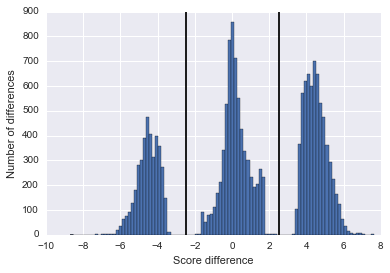

In [36]:
pd.Series(motif_d.values.flatten()).dropna().hist(bins=100)
ymin, ymax = plt.ylim()
plt.vlines(-2.5, ymin, ymax)
plt.vlines(2.5, ymin, ymax)
plt.ylabel('Number of differences')
plt.xlabel('Score difference');

It seems that a score difference greater than 2.5 in magnitude probably
represents a pretty big effect. I'll say these are disruptions.

In [37]:
motif_disrupt = motif_d.abs() >= 2.5
motif_disrupt = motif_disrupt[motif_disrupt.sum(axis=1) > 0]
motif_disrupt.to_csv(os.path.join(outdir, 'motif_disruption.tsv'), sep='\t')
#motif_disrupt.columns = ['{}_motif_disrupted'.format(x) for x in motif_disrupt.columns]
#gene_variants = gene_variants.merge(motif_disrupt, left_on='location', right_index=True, how='left')

In [38]:
print('{:,} variants disrupt a motif.'.format(motif_disrupt.shape[0]))

3,176 variants disrupt a motif.


In [39]:
# I'll convert the peak_overlaps into TF overlaps.
tdf = motif_disrupt.copy(deep=True)
tdf.columns = [motif_info.ix[x, 'target'] for x in tdf.columns]
d = {}
for c in tdf.columns:
    t = tdf[c]
    if len(t.shape) == 2:
        d[c] = t[c].sum(axis=1) > 0
    else:
        d[c] = t
tf_disrupt = pd.DataFrame(d)
tf_disrupt.to_csv(os.path.join(outdir, 'tf_disruption.tsv'), sep='\t')

In [40]:
t = pd.DataFrame([tf_disrupt.index], index=['location']).T
t['tf_disrupt'] = True
gene_variants = gene_variants.merge(t, how='outer')
gene_variants.ix[gene_variants['tf_disrupt'].isnull(), 'tf_disrupt'] = False

## CNV eQTLS

I'll mark which genes have an overlapping significant CNV.

In [41]:
t = pd.DataFrame(index=list(set(cnv_gv[cnv_gv.cnv_overlaps_gene].gene_id)))
t['cnv_eqtl'] = True
gene_variants = gene_variants.merge(t, how='outer', left_on='gene_id', right_index=True)
gene_variants.ix[gene_variants.cnv_eqtl.isnull(), 'cnv_eqtl'] = False

In [42]:
fn = os.path.join(outdir, 'gene_variants_annotated.pickle')
gene_variants.to_pickle(fn)

## Phasing and ASE

Let's consider a putative eQTN. Let's assume that the direction of effect is such that
the homozygous alternative genotype has lowest expression. If we have the correct eQTN,
a subject who is het for the putative eQTN should see lower expression for the haplotype
that contains the alt variant. I can check this for SNVs given that our SNVs are phased.

## Feature Exploration

In [43]:
n = gene_variants.shape[0]
print('{:,} total SNV and indel associations.'.format(n))
n = len(set(gene_variants.location))
print('{:,} total distinct SNV and indels with significant associations.'.format(n))

252,480 total SNV and indel associations.
195,047 total distinct SNV and indels with significant associations.


In [44]:
n = len(set(gene_variants[gene_variants.nmd == True].gene_id))
print('{:,} genes with a significant NMD variant.'.format(n))
n = len(set(gene_variants[gene_variants.cnv_eqtl == True].gene_id))
print('{:,} genes with a significant overlapping CNV.'.format(n))
n = len(set(gene_variants[gene_variants.cnv_eqtl == True].gene_id) |
        set(gene_variants[gene_variants.nmd == True].gene_id))
print('{:,} total in these groups.'.format(n))

11 genes with a significant NMD variant.
132 genes with a significant overlapping CNV.
142 total in these groups.


In [45]:
gene_variants.variant_type.value_counts()

snv    224998
del     15134
ins     12321
Name: variant_type, dtype: int64

In [46]:
n = (gene_variants.gene_id.value_counts() > 1).value_counts()[False]
print('{:,} of {:,} genes have only one significant variant.'.format(n, len(set(gene_variants.gene_id))))

2,134 of 5,579 genes have only one significant variant.


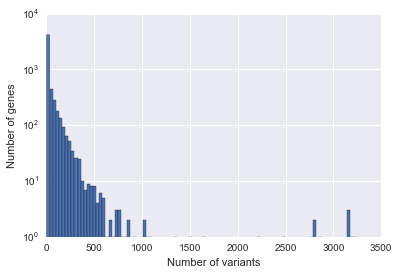

In [47]:
gene_variants.gene_id.value_counts().hist(bins=100, log=True)
plt.ylabel('Number of genes')
plt.xlabel('Number of variants');

In [48]:
gene_gb = gene_variants.groupby('gene_id')
num_genes = len(set(gene_variants.gene_id))

In [49]:
n = (gene_gb.exonic.sum() > 0).value_counts()[True]
print('{:,} of {:,} genes have at least one significant exonic variant.'.format(
    n, num_genes))
m = (gene_gb.exonic_same_gene.sum() > 0).value_counts()[True]
print('{:,} of these {:,} genes have at least one significant variant in their own exon.'.format(
    m, n))

2,692 of 5,579 genes have at least one significant exonic variant.
2,013 of these 2,692 genes have at least one significant variant in their own exon.


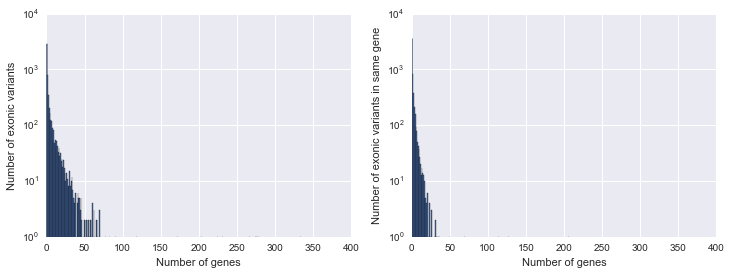

In [50]:
fig, axs = plt.subplots(1, 2, figsize=[12, 4])
ax = gene_gb.exonic.sum().hist(log=True, bins=range(0, int(gene_gb.exonic.sum().max())), ax=axs[0])
ax.set_ylabel('Number of exonic variants')
ax.set_xlabel('Number of genes')
ax = gene_gb.exonic_same_gene.sum().hist(log=True, bins=range(0, int(gene_gb.exonic.sum().max())), ax=axs[1])
ax.set_ylabel('Number of exonic variants in same gene')
ax.set_xlabel('Number of genes');

In [51]:
n = (gene_gb.utr.sum() > 0).value_counts()[True]
print('{:,} of {:,} genes have at least one significant UTR variant.'.format(
    n, len(set(gene_variants.gene_id))))
m = (gene_gb.utr_same_gene.sum() > 0).value_counts()[True]
print('{:,} of these {:,} genes have at least one significant variant in their own UTR.'.format(
    m, n))

2,029 of 5,579 genes have at least one significant UTR variant.
1,309 of these 2,029 genes have at least one significant variant in their own UTR.


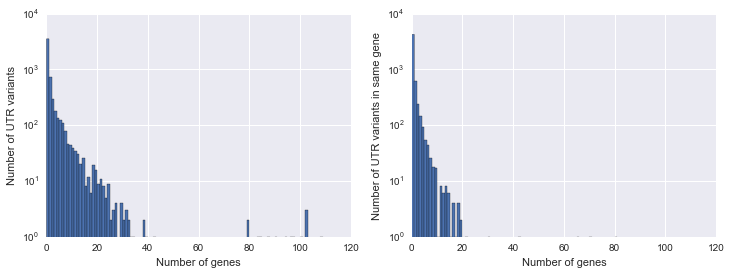

In [52]:
fig, axs = plt.subplots(1, 2, figsize=[12, 4])
ax = gene_gb.utr.sum().hist(log=True, bins=range(0, int(gene_gb.utr.sum().max())), ax=axs[0])
ax.set_ylabel('Number of UTR variants')
ax.set_xlabel('Number of genes')
ax = gene_gb.utr_same_gene.sum().hist(log=True, bins=range(0, int(gene_gb.utr.sum().max())), ax=axs[1])
ax.set_ylabel('Number of UTR variants in same gene')
ax.set_xlabel('Number of genes');

In [53]:
for c in [x for x in gene_variants.columns if 'dnase' in x]:
    vc = gene_variants[c].value_counts()
    print('{}\t{:.2f}%'.format(c, float(vc[True]) / vc.sum()))

iPS_DF_6.9_roadmap_dnase	0.05%
iPS_DF_19.11_roadmap_dnase	0.05%
H1_roadmap_dnase	0.04%
H9_roadmap_dnase	0.05%
iPSC_ENCSR000EKK_dnase	0.04%
iPSC_ENCSR000EKJ_dnase	0.04%
iPSC_ENCSR000EKI_dnase	0.05%
iPSC_ENCSR000EKH_dnase	0.02%
H7-hESC_ENCSR000EMZ_dnase	0.02%
H1-hESC_ENCSR000EMU_dnase	0.02%
H9_ENCSR000EJP_dnase	0.02%
H7-hESC_ENCSR000EJO_dnase	0.07%
H1-hESC_ENCSR000EJN_dnase	0.06%


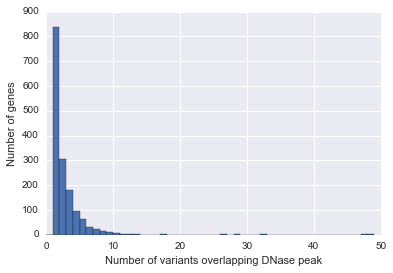

In [54]:
vc = gene_variants.ix[gene_variants['H1-hESC_ENCSR000EMU_dnase'] == True, 'gene_id'].value_counts()
vc.hist(bins=range(0, vc.max() + 1))
plt.ylabel('Number of genes')
plt.xlabel('Number of variants overlapping DNase peak');

In [55]:
gene_variants['significance.level_maurano'].value_counts()

not_imbalanced           12057
imbalanced_(5%_FDR)       2523
imbalanced_(0.1%_FDR)      281
Name: significance.level_maurano, dtype: int64

In [56]:
maurano_res['significance.level_maurano'].value_counts()

not_imbalanced           297687
imbalanced_(5%_FDR)       55141
imbalanced_(0.1%_FDR)      9456
Name: significance.level_maurano, dtype: int64

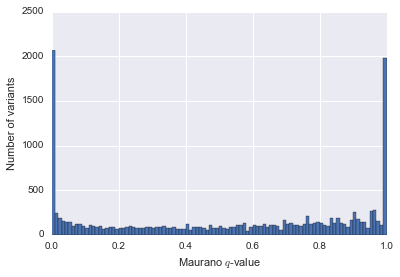

In [57]:
gene_variants['q.value_maurano'].hist(bins=100)
plt.ylabel('Number of variants')
plt.xlabel('Maurano $q$-value');

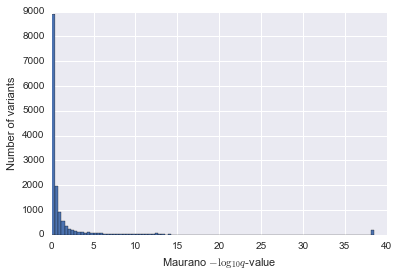

In [58]:
se = gene_variants['q.value_maurano'].dropna()
se += se[se > 0].min()
(-np.log10(se)).hist(bins=100)
plt.ylabel('Number of variants')
plt.xlabel('Maurano $-\log_{10}q$-value');

### Single variant genes

I'm going to look at genes for which there is only one significant
variant. In theory, these should often be the causal variants.

In [59]:
se = gene_variants.gene_id.value_counts() == 1
genes = set(se[se].index)
tdf = gene_variants[gene_variants.gene_id.apply(lambda x: x in genes)]

In [60]:
n = tdf.exonic.value_counts()[True]
print('{} of {} genes have an exonic variant.'.format(n, tdf.shape[0]))
n = tdf.utr.value_counts()[True]
print('{} of {} genes have a UTR variant.'.format(n, tdf.shape[0]))
n = tdf['H1-hESC_ENCSR000EMU_dnase'].value_counts()[True]
print('{} of {} genes have a variant in H1-hESC_ENCSR000EMU DNase peaks.'.format(n, tdf.shape[0]))

319 of 2134 genes have an exonic variant.
165 of 2134 genes have a UTR variant.
113 of 2134 genes have a variant in H1-hESC_ENCSR000EMU DNase peaks.


In [61]:
maurano_res['significance.level_maurano'].value_counts() / maurano_res.shape[0]

not_imbalanced           0.821695
imbalanced_(5%_FDR)      0.152204
imbalanced_(0.1%_FDR)    0.026101
Name: significance.level_maurano, dtype: float64

In [62]:
(gene_variants['significance.level_maurano'].value_counts() / 
 gene_variants['significance.level_maurano'].value_counts().sum())

not_imbalanced           0.811318
imbalanced_(5%_FDR)      0.169773
imbalanced_(0.1%_FDR)    0.018909
Name: significance.level_maurano, dtype: float64

In [63]:
tdf['significance.level_maurano'].value_counts() / tdf['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.757692
imbalanced_(5%_FDR)      0.230769
imbalanced_(0.1%_FDR)    0.011538
Name: significance.level_maurano, dtype: float64

In [64]:
tdf['significance.level_maurano'].value_counts()

not_imbalanced           197
imbalanced_(5%_FDR)       60
imbalanced_(0.1%_FDR)      3
Name: significance.level_maurano, dtype: int64

In [65]:
t = gene_variants.sort_values(by=['gene_id', 'pvalue'])
t = t.drop_duplicates(subset='gene_id')

In [66]:
t['significance.level_maurano'].value_counts() / t['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.723435
imbalanced_(5%_FDR)      0.259098
imbalanced_(0.1%_FDR)    0.017467
Name: significance.level_maurano, dtype: float64

In [67]:
n = len(set(tf_disrupt.index) & set(tdf.location))
print('The eQTL variant for {} genes disrupts a TF.'.format(n))
n = len(set(tf_disrupt.index) & set(tdf.location) & 
        set(tdf.ix[tdf['q.value_maurano'] < 0.05, 'location']))
print('{} of these are significant in Maurano et al.'.format(n))

The eQTL variant for 104 genes disrupts a TF.
18 of these are significant in Maurano et al.


## Fine Mapping

I'll start by removing genes are predicted to undergo NMD. I may also want to remove
genes where a CNV overlaps the gene.

In [346]:
n = qvalues.perm_sig.sum() - len(set(gene_variants.gene_id))
print('{} genes only had CNV associations.'.format(n))

40 genes only had CNV associations.


In [347]:
gene_variants_f = gene_variants[(gene_variants.gene_has_nmd_variant == False)]
a = len(set(gene_variants_f.gene_id))
b = len(set(gene_variants.gene_id))
print('{:,} of {:,} genes don\'t have a significant NMD variant.'.format(a, b))
print('{:,} genes have a significant NMD variant.'.format(b - a))

5,541 of 5,579 genes don't have a significant NMD variant.
38 genes have a significant NMD variant.


In [348]:
a = len(set(gene_variants_f.gene_id))
gene_variants_f = gene_variants_f[gene_variants_f.cnv_eqtl == False]
b = len(set(gene_variants_f.gene_id))
print('{:,} of {:,} genes don\'t have a significant overlapping CNV'.format(b, a))
print('{:,} genes have a significant overlapping CNV'.format(a - b))

5,437 of 5,541 genes don't have a significant overlapping CNV
104 genes have a significant overlapping CNV


In [349]:
n = qvalues.perm_sig.sum() - len(set(gene_variants_f.gene_id))
print('Removed {} genes due to CNV or NMD eQTLs.'.format(n))
print('{:,} remaining variants.'.format(len(set(gene_variants_f.location))))
print('{:,} remaining genes.'.format(len(set(gene_variants_f.gene_id))))

Removed 182 genes due to CNV or NMD eQTLs.
186,656 remaining variants.
5,437 remaining genes.


In [351]:
no_cnv_nmd_vars = gene_variants_f.location.drop_duplicates()
gene_variants_f.to_csv(os.path.join(outdir, 'no_cnv_nmd_vars_gv.tsv'), sep='\t')

In [352]:
a = peak_overlap.shape[1]
b = tf_overlap.shape[1]
print('Overlapped variants with {} ENCODE experiments for {} TFs.'.format(a, b))

Overlapped variants with 40 ENCODE experiments for 34 TFs.


In [353]:
n = sum(peak_overlap.ix[gene_variants_f.location.drop_duplicates()].sum(axis=1) > 0)
print('{:,} of {:,} variants overlapped at least one peak'.format(
        n, gene_variants_f.location.drop_duplicates().shape[0]))

7,630 of 186,656 variants overlapped at least one peak


In [354]:
n = sum(tf_disrupt.ix[gene_variants_f.location.drop_duplicates()].sum(axis=1) > 0)
print('{:,} of {:,} variants disrupted at least one TF.'.format(
        n, gene_variants_f.location.drop_duplicates().shape[0]))

3,058 of 186,656 variants disrupted at least one TF.


In [355]:
gene_variants_f = gene_variants_f[gene_variants_f.tf_disrupt]

In [356]:
len(set(gene_variants_f.gene_id))

1475

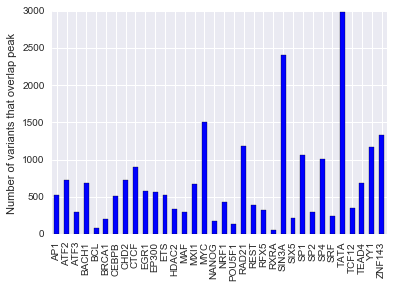

In [357]:
tf_overlap.sum().plot.bar()
plt.ylabel('Number of variants that overlap peak');

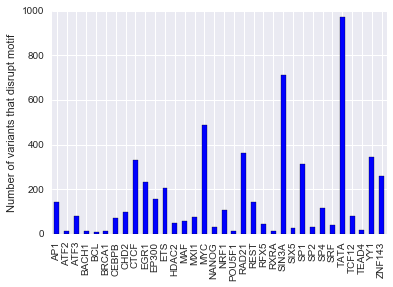

In [358]:
tf_disrupt.sum().plot.bar()
plt.ylabel('Number of variants that disrupt motif');

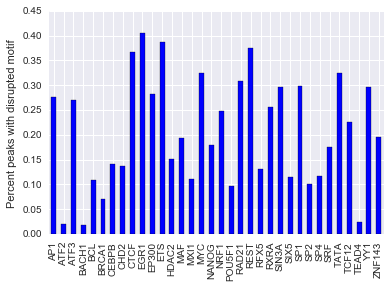

In [359]:
(tf_disrupt.sum() / tf_overlap.sum()).plot.bar()
plt.ylabel('Percent peaks with disrupted motif');

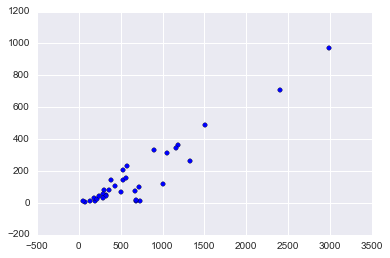

In [360]:
plt.scatter(tf_overlap.sum(), tf_disrupt.sum())

In [361]:
tf_disrupt['NANOG'].sum()

32

In [362]:
gene_variants_f['significance.level_maurano'].value_counts() / gene_variants_f['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.617097
imbalanced_(5%_FDR)      0.366874
imbalanced_(0.1%_FDR)    0.016028
Name: significance.level_maurano, dtype: float64

In [363]:
gene_variants['significance.level_maurano'].value_counts() / gene_variants['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.811318
imbalanced_(5%_FDR)      0.169773
imbalanced_(0.1%_FDR)    0.018909
Name: significance.level_maurano, dtype: float64

In [364]:
a = set(gene_variants_f.location) & set(maurano_res.index)
b = set(no_cnv_nmd_vars) & set(maurano_res.index)

In [365]:
print('{:,} of {:,} ({:.2f}%) putative eQTNs were significant in Maurano (q < 0.05).'.format(
        sum(maurano_res.ix[a, 'q.value_maurano'] < 0.05), len(a),
        sum(maurano_res.ix[a, 'q.value_maurano'] < 0.05) / float(len(a)) * 100))
print('{:,} of {:,} ({:.2f}%) sig. variants that were not putative eQTNs were significant in Maurano (q < 0.05).'.format(
        sum(maurano_res.ix[b, 'q.value_maurano'] < 0.05), len(b),
        sum(maurano_res.ix[b, 'q.value_maurano'] < 0.05) / float(len(b)) * 100))

359 of 974 (36.86%) putative eQTNs were significant in Maurano (q < 0.05).
2,345 of 12,392 (18.92%) sig. variants that were not putative eQTNs were significant in Maurano (q < 0.05).


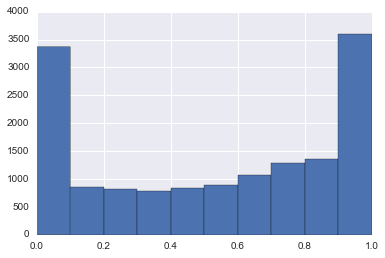

In [366]:
gene_variants['q.value_maurano'].hist()

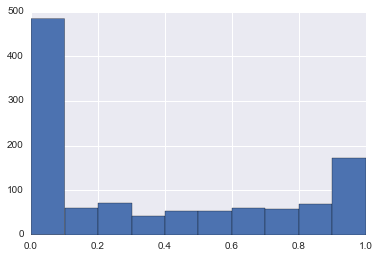

In [367]:
gene_variants_f['q.value_maurano'].hist()

In [368]:
n = len(set(gene_variants_f.gene_id))
a = sum(gene_variants_f.gene_id.value_counts() == 1)
print('{:,} of {:,} ({:.2f}%) eGenes have one putative eQTN.'.format(a, n, a / float(n) * 100))
a = sum(gene_variants_f.gene_id.value_counts() <= 5)
print('{:,} of {:,} ({:.2f}%) eGenes have five or less putative eQTNs.'.format(a, n, a / float(n) * 100))

735 of 1,475 (49.83%) eGenes have one putative eQTN.
1,357 of 1,475 (92.00%) eGenes have five or less putative eQTNs.


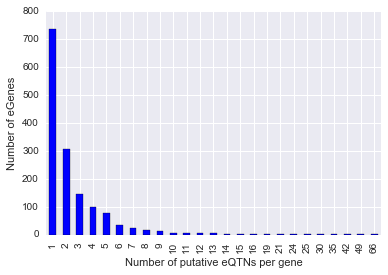

In [369]:
vc = gene_variants_f.gene_id.value_counts().value_counts().sort_index()
vc.plot(kind='bar')
plt.ylabel('Number of eGenes')
plt.xlabel('Number of putative eQTNs per gene');

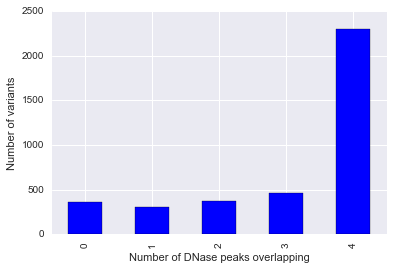

In [370]:
gene_variants_f['roadmap_dnase_num'] = \
    gene_variants_f[[x for x in gene_variants_f.columns 
                    if '_roadmap_dnase' in x]].sum(axis=1)

se = gene_variants_f.roadmap_dnase_num.value_counts()
se = se[range(se.shape[0])]
se.plot(kind='bar')
plt.ylabel('Number of variants')
plt.xlabel('Number of DNase peaks overlapping');

In [371]:
a = gene_variants_f[gene_variants_f.roadmap_dnase_num > 0].drop_duplicates(subset='location').shape[0]
b = gene_variants_f.drop_duplicates(subset='location').shape[0]
print('{:,} of {:,} ({:.2f}%) putative eQTNs overlap a DHS.'.format(a, b, a / float(b) * 100))

2,765 of 3,058 (90.42%) putative eQTNs overlap a DHS.


[Wen et al. 2015](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1005176) says 50% of cis-eQTLs are concentrated within 20kb of the TSS.

In [372]:
n = sum(gene_variants_f.tss_dist_abs < 20000)
p = float(n) / gene_variants_f.shape[0]
print('{:,} of {:,} ({:.1f}%) putative causal variants are within 20kb of the nearest TSS.'.format(
        n, gene_variants_f.shape[0], p * 100))

2,042 of 3,803 (53.7%) putative causal variants are within 20kb of the nearest TSS.


In [373]:
gene_variants_f.to_csv(os.path.join(outdir, 'peqtns.tsv'), sep='\t')

### 3D interactions

In [ ]:
3 + 

### Compare to GWAS

In [ ]:
def get_snpsnap():
    snpsnap_fns = glob.glob('/publicdata/SNPsnap_20151104/EUR_parse/*.tab')
    dfs = []
    for tab in snpsnap_fns:
        df = pd.read_table(tab, index_col=0, low_memory=False)
        tdf = df[['snp_maf', 'dist_nearest_gene_snpsnap_protein_coding',
                  'friends_ld08']]
        tdf.index = 'chr' + tdf.index
        dfs.append(tdf)
    snps = pd.concat(dfs)
    snps['maf_bin'] = pd.cut(snps.snp_maf, np.arange(0, 0.55, 0.05))
    snps['ld_bin'] = pd.cut(np.log10(snps.friends_ld08.replace(np.nan, 0) + 1), 10)
    snps['dist_bin'] = pd.cut(np.log10(snps.dist_nearest_gene_snpsnap_protein_coding
                                       + 1), 10)
    snps = snps[['maf_bin', 'ld_bin', 'dist_bin']]
    return snps
snpsnap = get_snpsnap()

In [ ]:
tdf = gene_variants_f[gene_variants_f.variant_type == 'snv'].drop_duplicates('location')
tdf.index = tdf.chrom + ':' + tdf.end.astype(int).astype(str)
tdf = tdf[['chrom', 'start', 'end', 'pvalue']]
tdf['start'] = tdf.start.astype(int)
tdf['end'] = tdf.end.astype(int)
ld_beds = glob.glob('/publicdata/1KGP_20151103/LD_20151110/tabix/*EUR*.bed.gz')
ld_beds = dict(zip([os.path.split(x)[1].split('_')[0] for x in ld_beds], ld_beds))
indep = cpb.analysis.ld_prune(tdf, ld_beds, snvs=list(snpsnap.index)).drop('pvalue', axis=1)
indep_bt = cpb.bedtools.intervals_to_bed((indep.chrom + ':' + indep.start.astype(str) + 
                                          '-' + indep.end.astype(str)))
indep_bt = indep_bt.sort()
indep_bt.saveas(os.path.join(outdir, 'independent_fine_mapped_variants.bed'));

In [ ]:
tdf = gene_variants_f[gene_variants_f.gene_name.apply(lambda x: 'HLA' not in x)]
tdf = tdf[tdf.variant_type == 'snv'].drop_duplicates('location')
tdf.index = tdf.chrom + ':' + tdf.end.astype(int).astype(str)
tdf = tdf[['chrom', 'start', 'end', 'pvalue']]
tdf['start'] = tdf.start.astype(int)
tdf['end'] = tdf.end.astype(int)
ld_beds = glob.glob('/publicdata/1KGP_20151103/LD_20151110/tabix/*EUR*.bed.gz')
ld_beds = dict(zip([os.path.split(x)[1].split('_')[0] for x in ld_beds], ld_beds))
indep_no_hla = cpb.analysis.ld_prune(tdf, ld_beds, snvs=list(snpsnap.index)).drop('pvalue', axis=1)
indep_no_hla_bt = cpb.bedtools.intervals_to_bed((indep_no_hla.chrom + ':' + indep_no_hla.start.astype(str) + 
                                          '-' + indep_no_hla.end.astype(str)))
indep_no_hla_bt = indep_no_hla_bt.sort()
indep_no_hla_bt.saveas(os.path.join(outdir, 'independent_fine_mapped_variants_no_hla.bed'));

In [ ]:
gvf_bt = cpb.bedtools.intervals_to_bed(list(set(gene_variants_f.location)))
gvf_bt = gvf_bt.sort()
gvf_bt.saveas(os.path.join(outdir, 'fine_mapped_variants.bed'));

In [ ]:
def calculate_overlap(eqtl_fn, gwas_fn):
    c = 'bedtools intersect -wb -a {} -b {} -sorted | cut -f 7 | sort | uniq | wc -l'.format(eqtl_fn, gwas_fn)
    count = int(subprocess.check_output(c, shell=True).strip())
    return eqtl_fn, gwas_fn, count

In [ ]:
grasp_phenos = pd.read_table('/publicdata/grasp2_20151104/variant_enrichment/grasp_phenotypes_500.tsv', 
                             index_col=0)
grasp_phenos.index = ['grasp_pheno_{}'.format(x) for x in grasp_phenos.index]

fns = glob.glob('/publicdata/grasp2_20151104/variant_enrichment/grasp_pheno_*/independent_snps.tsv')
num = []
for fn in fns:
    num.append(int(subprocess.check_output('wc -l {}'.format(fn), shell=True).strip().split()[0]))
    
grasp_phenos.ix[[x.split('/')[-2] for x in fns], 'number_independent'] = num

grasp_phenos_f = grasp_phenos[grasp_phenos.number_independent >= 200]
grasp_phenos_f = grasp_phenos_f[grasp_phenos_f.phenotype.apply(lambda x: 'expression' not in x.lower())]

In [ ]:
bt = pbt.BedTool('/publicdata/grasp2_20151104/variant_enrichment/grasp_pheno_7/independent_with_null_expanded.bed')
res = indep_no_hla_bt.intersect(bt, wo=True, sorted=True)
df = res.to_dataframe()
s = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)

In [ ]:
len(indep_no_hla_bt)

In [ ]:
len(indep_bt)

In [ ]:
set(gene_variants_f[gene_variants_f.location.apply(lambda x: x in s.values)].gene_name)

In [ ]:
bt = pbt.BedTool('/publicdata/grasp2_20151104/variant_enrichment/grasp_pheno_138/independent_with_null_expanded.bed')
res = gvf_bt.intersect(bt, wo=True, sorted=True)
df = res.to_dataframe()
s = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)

In [ ]:
set(gene_variants_f[gene_variants_f.location.apply(lambda x: x in s.values)].gene_name)

In [ ]:
s = gene_variants_f[[x for x in gene_variants_f.columns if '_tf_disrupted' in x]].sum()
s = s[s > 0]
s.sort_values(inplace=True, ascending=False)

In [ ]:
def calc_bed_enrichment_from_url(url, variants, variants_window):
    """Calculate enrichment for bed file from a URL for variants
    vs. variants_window"""
    from scipy.stats import fisher_exact
    bt = pbt.BedTool(cpb.general.read_gzipped_text_url(url), from_string=True)
    bt = bt.sort()
    bt = bt.merge()
    res = variants.intersect(bt, sorted=True, wo=True)
    eqtl_in_peak = len(res)
    eqtl_out_peak = len(variants) - eqtl_in_peak

    res = variants_window.intersect(bt, sorted=True, wo=True)
    not_eqtl_in_peak = 0
    for r in res:
        not_eqtl_in_peak += int(r.fields[-1])
    not_eqtl_in_peak -= eqtl_in_peak
    
    total = 0
    for r in variants_window:
        total += r.length
    not_eqtl_out_peak = total - not_eqtl_in_peak - eqtl_in_peak - eqtl_out_peak
    
    oddsratio, p = fisher_exact([[eqtl_in_peak, eqtl_out_peak],
                                 [not_eqtl_in_peak, not_eqtl_out_peak]])
    return url, oddsratio, p

In [ ]:
n = len(set(gene_variants_f.index) & set(lead_variants_single_f.index))
print('{:,} of my putative causal variants are also the most significant variants'.format(n))

In [ ]:
fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing', 'interactions.tsv')
interactions = pd.read_table(fn)

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing', 
                  'gene_to_containing_interactions.pickle')
gene_to_containing_interactions = cPickle.load(open(fn))

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_to_exon_gene.pickle')
chia_to_exon_gene = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_to_promoter_gene.pickle')
chia_to_promoter_gene = cPickle.load(open(fn))

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_peaks.bed')
chia_peaks = pbt.BedTool(fn)

TODO: Add in RNA pol2 chia pet? Adds some slop to stuff to get more overlaps?

In [ ]:
s = '\n'.join(gene_variants_f.location.apply(
        lambda x: '\t'.join(cpb.general.parse_region(x)))) + '\n'
var_bt = pbt.BedTool(s, from_string=True)
var_bt = var_bt.sort()
res = var_bt.intersect(chia_peaks, wo=True, sorted=True)
d = {}
for r in res:
    ind = '{}:{}-{}'.format(r.chrom, r.start, r.end)
    d[ind] = d.get(ind, set()) | set(['{}:{}-{}'.format(*r.fields[-4:-1])])
se = pd.Series(d)
    
gene_variants_f = gene_variants_f.merge(pd.DataFrame({'chia_peaks': se}), 
                                      left_on='location', right_index=True, how='left')

In [ ]:
s = '\n'.join(lead_variants_single_f.location.apply(
        lambda x: '\t'.join(cpb.general.parse_region(x)))) + '\n'
var_bt = pbt.BedTool(s, from_string=True)
var_bt = var_bt.sort()
res = var_bt.intersect(chia_peaks, wo=True, sorted=True)
d = {}
for r in res:
    ind = '{}:{}-{}'.format(r.chrom, r.start, r.end)
    d[ind] = d.get(ind, set()) | set(['{}:{}-{}'.format(*r.fields[-4:-1])])
se = pd.Series(d)
    
lead_variants_single_f = lead_variants_single_f.merge(pd.DataFrame({'chia_peaks': se}), 
                                                  left_on='location', right_index=True, how='left')

In [ ]:
def get_other_end(peaks):
    if type(peaks) is set:
        other_ends = []
        for p in peaks:
            other_ends += list(interactions.ix[interactions.peak1 == p, 'peak2'])
            other_ends += list(interactions.ix[interactions.peak2 == p, 'peak1'])
        return set(other_ends)
    else:
        return np.nan

In [ ]:
gene_variants_f['chia_interaction_peak'] = gene_variants_f.chia_peaks.apply(lambda x: get_other_end(x))
lead_variants_single_f['chia_interaction_peak'] = lead_variants_single_f.chia_peaks.apply(lambda x: get_other_end(x))

In [ ]:
def get_promoter_gene(peaks):
    if type(peaks) is set:
        peaks = peaks & set(chia_to_promoter_gene.index)
        genes = []
        for p in peaks:
            genes += list(chia_to_promoter_gene[p])
        out = set(genes)
        if len(out) == 0:
            return np.nan
        else:
            return out
    else:
        return np.nan

In [ ]:
sum(gene_variants_f.tss_dist_abs > 10000)

In [ ]:
sum(lead_variants_single_f.tss_dist_abs > 10000)

In [ ]:
gene_variants_f['chia_interaction_promoter_gene'] = \
    gene_variants_f.chia_interaction_peak.apply(lambda x: get_promoter_gene(x))
lead_variants_single_f['chia_interaction_promoter_gene'] = \
    lead_variants_single_f.chia_interaction_peak.apply(lambda x: get_promoter_gene(x))

In [ ]:
gene_variants_f['interacts_with_promoter'] = np.nan
t = gene_variants_f[gene_variants_f.chia_interaction_promoter_gene.isnull() == False]
se = t.apply(lambda x: x['gene_id'] in x['chia_interaction_promoter_gene'], axis=1)
gene_variants_f.ix[se.index, 'interacts_with_promoter'] = se

In [ ]:
lead_variants_single_f['interacts_with_promoter'] = np.nan
t = lead_variants_single_f[lead_variants_single_f.chia_interaction_promoter_gene.isnull() == False]
se = t.apply(lambda x: x['gene_id'] in x['chia_interaction_promoter_gene'], axis=1)
lead_variants_single_f.ix[se.index, 'interacts_with_promoter'] = se

In [ ]:
shared = set(lead_variants_single_f.index) & set(gene_variants_f.index)

In [ ]:
a = lead_variants_single_f.interacts_with_promoter.sum()
b = gene_variants_f.interacts_with_promoter.sum()
c = len(set(lead_variants_single_f[lead_variants_single_f.interacts_with_promoter == True].index) 
        & set(gene_variants_f[gene_variants_f.interacts_with_promoter == True].index))
print('{} lead variants and {} putative eQTNs ({} shared) '
      'interact with promoters.'.format(a, b, c))

In [ ]:
lead_interact = lead_variants_single_f.drop(shared).interacts_with_promoter.sum()
lead_no_interact = lead_variants_single_f.drop(shared).shape[0] - lead_interact
put_interact = gene_variants_f.drop(shared).interacts_with_promoter.sum()
put_no_interact = gene_variants_f.drop(shared).shape[0] - put_interact

In [ ]:
stats.fisher_exact([[put_interact, put_no_interact], [lead_interact, lead_no_interact]])

In [ ]:
interactions.

In [ ]:
interactions.head().T

In [ ]:
promoters = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_by_gene.bed')
df = promoters.to_dataframe()
df['gene'] = df.name.apply(lambda x: x.split('_')[0])
df['region'] = df.name.apply(lambda x: x.split('_')[2])
df.index = df.region
gb = df.groupby('gene')
gene_to_promoters = gb.groups

In [ ]:
def get_hic_interactions(vg):
    chrom,a,gene = vg.split(':')
    start,end = [int(x) for x in a.split('-')]
    r = '{}:{}-{}'.format(chrom, start, end)
    fn = ('/projects/CARDIPS/pipeline/Hi-C/7_indv_HiC/contact_matrices/'
          'merged/normalized/iPSC/iPSC.5Kb.nor.{}.bed.gz'.format(chrom))
    t = tabix.open(fn)
    lines = []
    res = t.querys(r)
    while True:
        try:
            lines.append(res.next())
        except StopIteration:
            break
    # Get promoter regions.
    ps = [cpb.general.parse_region(x) for x in gene_to_promoters[gene]]
    # Get indices of columns for promoter regions.
    cols = []
    for x in ps:
        cols += range(int(x[1]) / 5000, int(x[2]) / 5000 + 1)
    cols = sorted(list(set(cols)))
    vals = []
    # Get values for promoter regions.
    for line in lines:
        vals.append([float(line[x + 3]) for x in cols])
    df = pd.DataFrame(vals)
    df.columns = np.array(cols) * 5000
    df.index = np.arange((start / 5000) * 5000, (start / 5000 + df.shape[0]) * 5000, 5000)
    # Reflect over promoter regions and get interactions on other side.
    cnv_middle = int(start + (end - start) / 2.)
    promoter_middle = int(df.columns[0] + (df.columns[-1] - df.columns[0]) / 2.)
    null_start = int(2 * promoter_middle - cnv_middle - (end - start) / 2.)
    null_end = int(2 * promoter_middle - cnv_middle + (end - start) / 2.)
    if null_start < 0 or null_end < 0:
        return None, None
    else:
        r = '{}:{}-{}'.format(chrom, null_start, null_end)
        lines = []
        res = t.querys(r)
        while True:
            try:
                lines.append(res.next())
            except StopIteration:
                break
        if lines == []:
            return None, None
        else:            
            vals = []
            # Get values for promoter regions.
            for line in lines:
                vals.append([float(line[x + 3]) for x in cols])
            null_df = pd.DataFrame(vals)
            null_df.columns = np.array(cols) * 5000
            null_df.index = np.arange((null_start / 5000) * 5000, (null_start / 5000 + null_df.shape[0]) * 5000, 5000)
            return df, null_df

In [ ]:
real = []
null = []
dist = []
for i in gene_variants_f.index:
    df, null_df = get_hic_interactions(i)
    if df is not None:
        real.append(df.max().max())
        null.append(null_df.max().max())
        dist.append(abs(np.mean(df.columns) - np.mean(df.index)))
put_real = pd.Series(real)
put_null = pd.Series(null)

In [ ]:
real = []
null = []
dist = []
for i in lead_variants_single_f.index:
    df, null_df = get_hic_interactions(i)
    if df is not None:
        real.append(df.max().max())
        null.append(null_df.max().max())
        dist.append(abs(np.mean(df.columns) - np.mean(df.index)))
lead_real = pd.Series(real)
lead_null = pd.Series(null)

In [ ]:
plt.scatter(put_null * 10000, put_real * 10000)
plt.plot([0, 1], [0, 1])

In [ ]:
plt.scatter(lead_null * 10000, lead_real * 10000)
plt.plot([0, 1], [0, 1])

In [ ]:
sig_variants_f.tf_disruption.value_counts()

In [ ]:
sig_variants_f['significance.level_maurano'].value_counts()

In [ ]:
se = sig_variants_f[[x for x in sig_variants_f.columns if '_tf_disrupted' in x]].sum()
se.sort_values(inplace=True, ascending=False)

motif_cols = [x for x in sig_variants_f.columns if '_motif_disrupted' in x]
tdf = sig_variants_f[sig_variants_f.tf_disruption]

direction = []
motifs = []
for tf in motif_cols:
    t = tdf[tdf[tf] == True]
    if t.shape[0] > 0:
        motifs.append(tf)
        beta = t.beta
        beta.index = t.variant
        d = motif_d.ix[t.variant, '_'.join(tf.split('_')[0:2])]
        c = pd.crosstab(beta > 0, d > 0)
        a = 0
        if True in c.index and True in c.columns:
            a += c.ix[True, True]
        if False in c.index and False in c.columns:
            a += c.ix[False, False]
        b = 0
        if True in c.index and False in c.columns:
            b += c.ix[True, False]
        if False in c.index and True in c.columns:
            b += c.ix[False, True]
        direction.append([a, b])

In [ ]:
df = pd.DataFrame(direction, index=motifs, columns=['repress', 'activate'])
df['tf'] = [x.split('_')[0] for x in df.index]

In [ ]:
tf = df.groupby('tf').sum()

In [ ]:
tf

TODO: More likely to fall in enhancers?

In [ ]:
# GM12878_CTCF
# http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1872886
url = ('http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1872886&format=file&file='
       'GSM1872886%5FGM12878%5FCTCF%5FPET%5Fclusters%2Etxt%2Egz')

# GM12878_RNAPII
# http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1872887
url = ('http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1872887&format=file&file='
       'GSM1872887%5FGM12878%5FRNAPII%5FPET%5Fclusters%2Etxt%2Egz')
s = cpb.general.read_gzipped_text_url(url)
lines = [x.strip().split('\t') for x in s.split('\n')[:-1]]
gm_rnap = pd.DataFrame(lines, columns=['chr1', 'start1', 'end1',
                                       'chr2', 'start2', 'end2', 'num'])
for c in ['start1', 'start2', 'end1', 'end2', 'num']:
    gm_rnap[c] = gm_rnap[c].astype(int)

# HeLa_CTCF
# http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1872888
url = ('http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1872888&format=file&file='
       'GSM1872888%5FHeLa%5FCTCF%5FPET%5Fclusters%2Etxt%2Egz')

# HeLa_RNAPII
# http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1872889
url = ('http://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM1872889&format=file&file='
       'GSM1872889%5FHeLa%5FRNAPII%5FPET%5Fclusters%2Etxt%2Egz')
s = cpb.general.read_gzipped_text_url(url)
lines = [x.strip().split('\t') for x in s.split('\n')[:-1]]
hela_rnap = pd.DataFrame(lines, columns=['chr1', 'start1', 'end1',
                                       'chr2', 'start2', 'end2', 'num'])
for c in ['start1', 'start2', 'end1', 'end2', 'num']:
    hela_rnap[c] = hela_rnap[c].astype(int)

In [ ]:
hela_rnap.head()

TODO: I can also compare conservation.